# Classical Support Vector Classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import RocCurveDisplay, roc_curve

seed = 42
np.random.seed(42)

## Data preparation

We use the weather dataset by AccuWeather Service. Since 5xx denotes rain, we make it class 1 and refer others as class 0

In [2]:
df = pd.read_csv("weather/weather-010824-061024.csv")
df.shape

(1658, 12)

In [3]:
def weather_map(x):
    val = int(x / 100)
    if val == 5:
        return 1
    return 0


df["is_rain"] = df.cod_weather.apply(weather_map)

In [4]:
df.is_rain.value_counts()

is_rain
0    1625
1      33
Name: count, dtype: int64

In [5]:
features = [
    "hum",
    "pres",
    "rain_1h",
    "wind_speed",
    "wind_deg",
    "clouds_all",
    "max_temp",
    "min_temp",
    "ave_temp",
]
target = "is_rain"

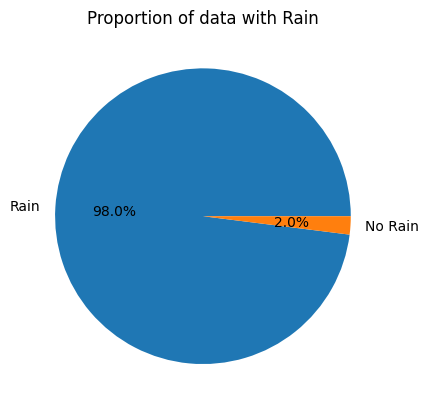

In [6]:
labels = ["Rain", "No Rain"]

rain_or_not = df["is_rain"].value_counts().tolist()
values = [rain_or_not[0], rain_or_not[1]]

plt.pie(df["is_rain"].value_counts(), labels=labels, autopct="%1.1f%%")
plt.title("Proportion of data with Rain")
plt.show()

We can already see that the dataset is imbalanced with only 2 percent of rain data. Using accuracy score as a metric with imbalanced datasets will be usually high and misleading. We use different techniques and metrics below better suited for this dataset.

First we split the dataset into train and test.

In [7]:
X = df[features].to_numpy()
y = df[target].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((1160, 9), (498, 9))

In [8]:
sum(y_train == 1), sum(y_test == 1)

(23, 10)

## Baseline

The standard SVC model. Our goal is to optimize for Recall which is the ability of a model to find all the relevant cases within a data set. In most high-risk detection cases, recall is a more important evaluation metric than precision.

In the case of predicting rain, we want to avoid false negatives as much as possible. Rains can cost us a lot and thus we want to take appropriate measures to predict them and save lives.

In [9]:
model_name = 'svc'
base_model = SVC(random_state=seed, probability=True)
ro_model = clone(base_model)
ru_model = clone(base_model)
smote_tomek_model = clone(base_model)
balanced_model = SVC(random_state=seed, class_weight='balanced', probability=True)

In [10]:
# We are going to ensure that we have the same splits of the data every time.
kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(base_model, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.   0.75 0.4  0.6  0.4 ]
Average Cross Validation Recall score: 0.43


### Hyperparameter Tuning Using GridSearchCV

In [11]:
params = {
    "degree": [2, 4, 6, 8],
    "C": np.linspace(0.5, 4.0, 15),
    "kernel": ["rbf", "poly", "linear", "sigmoid"],
    "random_state": [seed],
}

grid = GridSearchCV(base_model, param_grid=params, cv=kf, scoring="recall").fit(
    X_train, y_train
)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'C': 0.75, 'degree': 2, 'kernel': 'sigmoid', 'random_state': 42}
Best score: 0.66


In [12]:
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

baseline_Recall = recall_score(y_test, y_pred)
baseline_Precision = precision_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)
baseline_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[487   1]
 [  5   5]]


In [13]:
ndf = [(baseline_Recall, baseline_Precision, baseline_f1, baseline_accuracy)]

baseline_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
baseline_score.insert(0, f"{model_name} with", "Baseline")
baseline_score

,svc with,Recall,Precision,F1 Score,Accuracy
0,Baseline,0.5,0.833333,0.625,0.987952


The result Recall score for a test set is 50%. We will improve this score in below parts of the notebook.

## Random oversampling

Randomly duplicate examples in the minority class. Importantly, change to the class distribution should be only applied to the training dataset.

In [14]:
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), ro_model)
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.25 1.   1.   0.6  0.8 ]
Average Cross Validation Recall score: 0.7300000000000001


In [15]:
new_params = {f'{model_name}__' + key: params[key] for key in params}
grid_over = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over.fit(X_train, y_train)

print('Best parameters:', grid_over.best_params_)
print('Best score:', grid_over.best_score_)

/home/gopald/Documents/jetix/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'svc__C': 0.5, 'svc__degree': 2, 'svc__kernel': 'sigmoid', 'svc__random_state': 42}
Best score: 0.95


In [16]:
y_pred = grid_over.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

over_Recall = recall_score(y_test, y_pred)
over_Precision = precision_score(y_test, y_pred)
over_f1 = f1_score(y_test, y_pred)
over_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[476  12]
 [  0  10]]


In [17]:
ndf = [(over_Recall, over_Precision, over_f1, over_accuracy)]

over_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_score.insert(0, f'{model_name} with', 'Random Oversampling')
over_score

,svc with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,1.0,0.454545,0.625,0.975904


## Smote Tomek

SMOTE (Synthetic Minority Oversampling Technique) synthesize elements for the minority class while Tomek Links is an under-sampling technique. It can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data and then remove it.

A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. 

In [18]:
SMOTETomek_pipeline = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy="majority")),
    smote_tomek_model,
)
score = cross_val_score(SMOTETomek_pipeline, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.25 1.   1.   0.6  0.8 ]
Average Cross Validation Recall score: 0.7300000000000001


In [19]:
new_params = {f"{model_name}__" + key: params[key] for key in params}
SMOTETomek_grid = GridSearchCV(
    SMOTETomek_pipeline, param_grid=new_params, cv=kf, scoring="recall"
).fit(X_train, y_train)
print("Best parameters:", SMOTETomek_grid.best_params_)
print("Best score:", SMOTETomek_grid.best_score_)

Best parameters: {'svc__C': 1.0, 'svc__degree': 6, 'svc__kernel': 'sigmoid', 'svc__random_state': 42}
Best score: 0.96


/home/gopald/Documents/jetix/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [20]:
y_pred = SMOTETomek_grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

SMOTETomek_Recall = recall_score(y_test, y_pred)
SMOTETomek_Precision = precision_score(y_test, y_pred)
SMOTETomek_f1 = f1_score(y_test, y_pred)
SMOTETomek_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[466  22]
 [  1   9]]


In [21]:
ndf = [
    (
        SMOTETomek_Recall,
        SMOTETomek_Precision,
        SMOTETomek_f1,
        SMOTETomek_accuracy,
    )
]

SMOTETomek_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
SMOTETomek_score.insert(0, f'{model_name} with', "SMOTE + Tomek")
SMOTETomek_score

,svc with,Recall,Precision,F1 Score,Accuracy
0,SMOTE + Tomek,0.9,0.290323,0.439024,0.953815


## Class weighted model

Machine learning models provide a parameter called `class_weights` with which we can specify a higher weight for the minority class using a dictionary.

Without weights set, the model treats each point as equally important. Weights scale the loss function. As the model trains on each point, the error will be multiplied by the weight of the point. The estimator will try to minimize error on the more heavily weighted classes, because they will have a greater effect on error, sending a stronger signal.

In [22]:
score5 = cross_val_score(balanced_model, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.25 0.75 1.   0.6  0.8 ]
Average Cross Validation Recall score: 0.68


In [23]:
grid_b = GridSearchCV(balanced_model, param_grid=params, cv=kf, scoring="recall").fit(
    X_train, y_train
)

y_pred = grid_b.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

grid_b_Recall = recall_score(y_test, y_pred)
grid_b_Precision = precision_score(y_test, y_pred)
grid_b_f1 = f1_score(y_test, y_pred)
grid_b_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[439  49]
 [  0  10]]


In [24]:
ndf = [(grid_b_Recall, grid_b_Precision, grid_b_f1, grid_b_accuracy)]

grid_b_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
grid_b_score.insert(0, f'{model_name} with', "Class weights")
grid_b_score

,svc with,Recall,Precision,F1 Score,Accuracy
0,Class weights,1.0,0.169492,0.289855,0.901606


In [25]:
predictions = pd.concat(
    [baseline_score, over_score, SMOTETomek_score, grid_b_score], ignore_index=True, sort=False
)
predictions.sort_values(by=["Recall"], ascending=False)

,svc with,Recall,Precision,F1 Score,Accuracy
1,Random Oversampling,1.0,0.454545,0.625000,0.975904
3,Class weights,1.0,0.169492,0.289855,0.901606
2,SMOTE + Tomek,0.9,0.290323,0.439024,0.953815
0,Baseline,0.5,0.833333,0.625000,0.987952


In [26]:
predictions.to_csv('results/svc.csv')

## Summary

- We observe that the random oversampling model has the highest recall score while costing on precision.
- The baseline model has a 50% recall score but has the highest precision.

Considering the trade-off between recall and precision, random oversampling model is the best. Below we see the AUC score of the random oversampling model.

## ROC-AUC curve

In [27]:
y_pred = grid_over.predict(X_test)
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for SVC with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for SVC with Class weights: 0.9877


/home/gopald/Documents/jetix/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


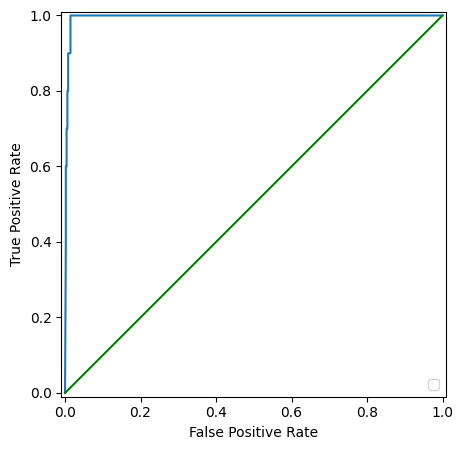

In [28]:
y_proba = grid_over.predict_proba(X_test)

def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color="g")
    

plot_auc_roc_curve(y_test, y_proba[:, 1])

We see that random oversampling model has a 98.77% AUC score which means there is around 98% chance that the model is able to differentiate between rain and no-rain based on other features.

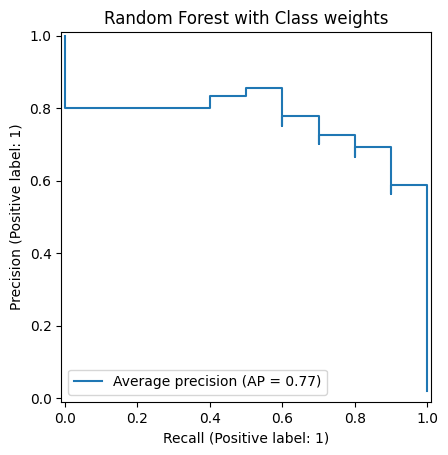

In [29]:
display = PrecisionRecallDisplay.from_estimator(
    grid_over, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")

We can clearly see the point where we have to start trading a lot of Precision for better Recall score!